In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install fastai==1.0.61

In [3]:
# !pip install timm

In [4]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from PIL import Image
import os
from glob import glob
import cv2
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F


In [5]:
from utils import interleave, de_interleave, show_batch, AverageMeter, show_grid, get_config
from learner import FixMatch, BaseLine
from dataset import GIDataset, get_transform

In [6]:
config = get_config('./configs/local_supervised_groupbycat.yaml')

In [7]:
config

{'DATA': {'PATH': 'D:\\data\\endoscopic\\hyper_kvasir\\labeled_images_deform',
  'ANNO': '../resource/hyper_kvasir/full_labeled_group.csv',
  'IMG_SIZE': 224,
  'BATCH_SIZE': 8,
  'NUM_WORKERS': 0},
 'MODEL': {'NUM_CLASSES': 6},
 'TRAIN': {'IS_SSL': False,
  'EPOCHS': 10,
  'BASE_LR': 0.001,
  'WARMUP_LR': 0.0005,
  'WEIGHT_DECAY': 1e-05,
  'WARMUP_EPOCHS': 20,
  'OPT_NAME': 'Adam',
  'EPS': 1e-08,
  'BETAS': [0.9, 0.999],
  'MOMENTUM': 0.9,
  'FREQ_EVAL': 5,
  'SCH_NAME': 'step',
  'LR_DECAY': 0.8,
  'USE_EMA': True,
  'EMA_DECAY': 0.999,
  'EVAL_STEP': 512,
  'CLS_WEIGHT': True}}

In [8]:
df_full = pd.read_csv(config['DATA']['ANNO'])
df_full.head()

,Organ,Classification,Finding,Image,Categories,is_valid,Groupby_Categories
0,lower-gi-tract,therapeutic-interventions,dyed-resection-margins,lower-gi-tract/therapeutic-interventions/dyed-...,0,False,0
1,lower-gi-tract,quality-of-mucosal-views,bbps-2-3,lower-gi-tract/quality-of-mucosal-views/bbps-2...,0,False,0
2,upper-gi-tract,pathological-findings,barretts-short-segment,upper-gi-tract/pathological-findings/barretts-...,1,False,5
3,lower-gi-tract,quality-of-mucosal-views,bbps-0-1,lower-gi-tract/quality-of-mucosal-views/bbps-0...,0,False,0
4,upper-gi-tract,anatomical-landmarks,z-line,upper-gi-tract/anatomical-landmarks/z-line/87c...,0,False,0


In [9]:
# config = {}

# config['data_path'] = _HYPER_KVASIR
# config['size'] = 224
# config['num_classes'] = 6
# config['batch_size'] = 16
# config['num_workers'] = 0
# config['output_nodes'] = 1
# config['epochs'] = 10
# config['lr'] = 1e-3
# config['mu'] = 7

# config['lr'] = 1e-3
# config['lr_step_size'] = 10
# config['lr_gamma'] = 0.8

# config['momentum'] = 0.9
# config['weight_decay'] = 0.05
# config['eval_step'] = 16
# config['threshold'] = 0.95
# config['T'] = 1.0
# config['lambda_u'] = 0.9
# config['freq_eval'] = 1
# config['sch_name'] = 'step'
# config['use_ema'] = True
# config['ema_decay'] = 0.999

In [10]:
df_train = df_full[df_full['is_valid']==False]
## break down into labeled and unlabeled set
# df_labeled, df_unlabeled = train_test_split(df_train, test_size = 0.9, random_state = 0)
# df_labeled = df_labeled.reset_index();
# df_unlabeled = df_unlabeled.reset_index();

In [11]:
df_train['Groupby_Categories'].value_counts()

0    6013
2     815
5     641
4     306
3     178
1      43
Name: Groupby_Categories, dtype: int64

In [12]:
df_valid = df_full[df_full['is_valid']==True]
df_valid['Groupby_Categories'].value_counts()

0    2007
2     241
5     230
4      97
3      82
1       9
Name: Groupby_Categories, dtype: int64

In [13]:
# train_labeled_ds = GIDataset(df = df_labeled, config = config, transforms = get_transform(config, is_train=True))
# train_unlabeled_ds = GIDataset(df = df_unlabeled, config = config, transforms = get_transform(config, is_train=True, is_labeled=False))
train_ds = GIDataset(df = df_full[df_full['is_valid']==False], config = config, transforms = get_transform(config, is_train=True))
valid_ds = GIDataset(df = df_full[df_full['is_valid']==True] , config = config, transforms = get_transform(config))

In [14]:
# train_labeled_dl = DataLoader(train_labeled_ds, 
#                               sampler=RandomSampler(train_labeled_ds),
#                               batch_size = config['batch_size'], 
#                               num_workers = config['num_workers'])

# train_unlabeled_dl = DataLoader(train_unlabeled_ds, 
#                               sampler=RandomSampler(train_unlabeled_ds),
#                               batch_size = config['batch_size']*config['mu'], 
#                               num_workers = config['num_workers'])

train_dl = DataLoader(train_ds, 
                      sampler=RandomSampler(train_ds),
                      batch_size = config['DATA']['BATCH_SIZE'], 
                      num_workers = config['DATA']['NUM_WORKERS'])

valid_dl = DataLoader(valid_ds, 
                      sampler=SequentialSampler(valid_ds),
                      batch_size = config['DATA']['BATCH_SIZE'], 
                      num_workers = config['DATA']['NUM_WORKERS'])

torch.Size([8, 3, 224, 224])
tensor([0, 0, 0, 2, 5, 0, 0, 0])


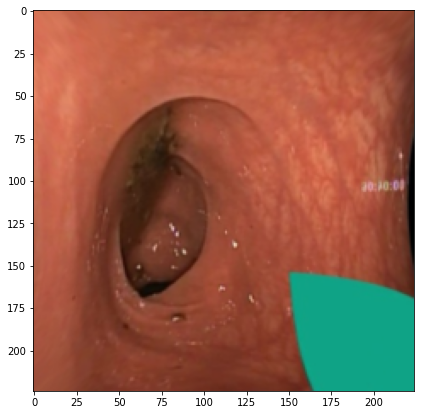

In [15]:
for x, y in train_dl:
    print(x.shape)
    print(y)
    break
show_batch(x[0,:,:])

torch.Size([8, 3, 224, 224])
tensor([0, 0, 2, 0, 5, 0, 0, 2])


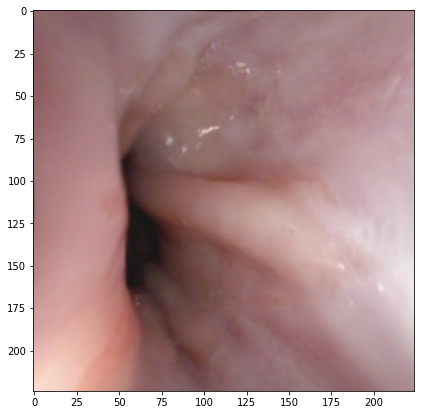

In [16]:
for x, y in valid_dl:
    print(x.shape)
    print(y)
    break
show_batch(x[0,:,:])

In [17]:
# x[0][100,:,:].shape

In [18]:
# for x, y in train_unlabeled_dl:
#     # print(x)
#     # print(y)
#     break
# show_grid([x[0][100,:,:]]+[x[1][100,:,:]])

In [19]:
model = nn.Sequential(timm.create_model('densenet161',pretrained=True,num_classes = config['MODEL']['NUM_CLASSES']))

In [20]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [21]:
train_dl.dataset.df['Groupby_Categories']

0       0
1       0
2       5
3       0
4       0
       ..
7991    0
7992    0
7993    0
7994    5
7995    0
Name: Groupby_Categories, Length: 7996, dtype: int64

In [22]:
classifier = BaseLine(model = model,
                      opt_func=config['TRAIN']['OPT_NAME'], 
                      device = device)
classifier.get_dataloader(train_dl, valid_dl)
classifier.get_config(config)
# classifier.get_dataloader((train_labeled_dl, train_unlabeled_dl), valid_dl)


In [23]:
# config

In [24]:
# classifier.fit()

ERROR! Session/line number was not unique in database. History logging moved to new session 1148


In [28]:
classifier.lr_scheduler.step_update(0*len(train_dl)+200)

In [29]:
# config

In [30]:
classifier.optimizer.param_groups[0]["lr"]

1.329227995784919e-07

In [ ]:
# classifier.save_checkpoint('./')

In [ ]:
# classifier.load_checkpoint('./05_08_2022_19_21_56.pth')